# **Bước 1: Chuẩn bị dữ liệu**

In [1]:
# Khai báo thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
import warnings
import seaborn as sns
#Các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM,Dropout,Dense #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
#kiểm tra độ chính xác của mô hình
from sklearn.metrics import mean_squared_error # do độ chính xác của mô hình dự đoán
from sklearn.metrics import r2_score #đo múc độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo phần trăm sai số tuyệt đối trung bình
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [2]:
# Kết nối với Google Drive
from google.colab import drive
drive.mount("/drive")

Mounted at /drive


In [3]:
df = pd.read_csv('/drive/MyDrive/ĐỒ ÁN VÀ THỰC TẬP/ĐỒ ÁN/data/city_temperature.csv')
df.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


In [4]:
# in ra số dòng số cột
print("Số dòng, số cột:", df.shape)

Số dòng, số cột: (2906327, 8)


In [5]:
df.columns

Index(['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year',
       'AvgTemperature'],
      dtype='object')

In [6]:
# in ra thông tin tập dữ liệu
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 177.4+ MB


In [7]:
df.dtypes

Region             object
Country            object
State              object
City               object
Month               int64
Day                 int64
Year                int64
AvgTemperature    float64
dtype: object

# **Bước 2: Tiền xử lý dữ liệu**

In [8]:
# Đếm số lượng giá trị duy nhất trong mỗi cột và sắp xếp theo thứ tự tăng dần
unique_counts = df.nunique().sort_values(ascending=True)
unique_counts

Region               7
Month               12
Year                28
Day                 32
State               52
Country            125
City               321
AvgTemperature    1517
dtype: int64

In [9]:
# Tính toán các thống kê mô tả của các cột trong DataFram
statistics = df.describe().transpose()
statistics

,count,mean,std,min,25%,50%,75%,max
Month,2906327.0,6.469163,3.456489,1.0,3.0,6.0,9.0,12.0
Day,2906327.0,15.716816,8.800534,0.0,8.0,16.0,23.0,31.0
Year,2906327.0,2006.623909,23.382259,200.0,2001.0,2007.0,2013.0,2020.0
AvgTemperature,2906327.0,56.004921,32.123594,-99.0,45.8,62.5,75.5,110.0


In [10]:
df["Region"].value_counts()

North America                        1556681
Europe                                381990
Asia                                  316663
Africa                                251118
South/Central America & Carribean     219530
Middle East                           124749
Australia/South Pacific                55596
Name: Region, dtype: int64

In [11]:
df["Country"].value_counts()

US                   1455337
Canada                 74245
Australia              46330
China                  46329
India                  37063
                      ...   
Guyana                  5065
Israel                  4641
Burundi                 4543
Georgia                 4378
Serbia-Montenegro       3427
Name: Country, Length: 125, dtype: int64

In [12]:
df['City'].value_counts()

Springfield      18530
Columbus         18530
Portland         18530
Washington DC    18530
Washington       18530
                 ...  
Frankfurt         4136
Flagstaff         3574
Pristina          3427
Yerevan           3226
Bonn              3133
Name: City, Length: 321, dtype: int64

In [13]:
# Kiểm tra số lượng giá trị thiếu trong từng cột của DataFrame
missing_values = df.isnull().sum()
missing_values

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64

In [14]:
(df['State'].isna().sum() / df['State'].shape[0])*100

49.92521488462929

In [15]:
df = df.drop('State', axis=1)

In [16]:
df.describe(include = 'object')

,Region,Country,City
count,2906327,2906327,2906327
unique,7,125,321
top,North America,US,Springfield
freq,1556681,1455337,18530


In [17]:
# Kiểm tra số lượng giá trị duy nhất từ tất cả các kiểu dữ liệu đối tượng
df.select_dtypes(include='object').nunique()

Region       7
Country    125
City       321
dtype: int64

In [18]:
print(df.Day.unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31  0]


In [19]:
print(df.Year.unique())

[1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008
 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020  201  200]


In [20]:
df =df[ (df['Year'] != 200) & (df['Year'] != 201) & (df['Day'] != 0) ]

In [21]:
df['Date'] = pd.to_datetime(df[['Year','Month','Day']])

In [22]:
df.sample(10)

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
143631,Africa,Malawi,Lilongwe,6,21,2002,-99.0,2002-06-21
1520043,North America,US,Phoenix,9,16,1996,80.3,1996-09-16
221925,Africa,Tunisia,Tunis,4,28,2010,64.7,2010-04-28
617401,Australia/South Pacific,New Zealand,Auckland,1,4,2004,68.6,2004-01-04
1719129,North America,US,Jacksonville,5,3,2016,78.5,2016-05-03
1846047,North America,US,Peoria,9,10,2008,60.3,2008-09-10
925725,Europe,Spain,Madrid,4,10,2005,44.7,2005-04-10
361978,Asia,Japan,Osaka,7,25,2003,74.2,2003-07-25
1494617,North America,US,Anchorage,12,24,2012,8.9,2012-12-24
1532394,North America,US,Tucson,2,27,2005,53.5,2005-02-27


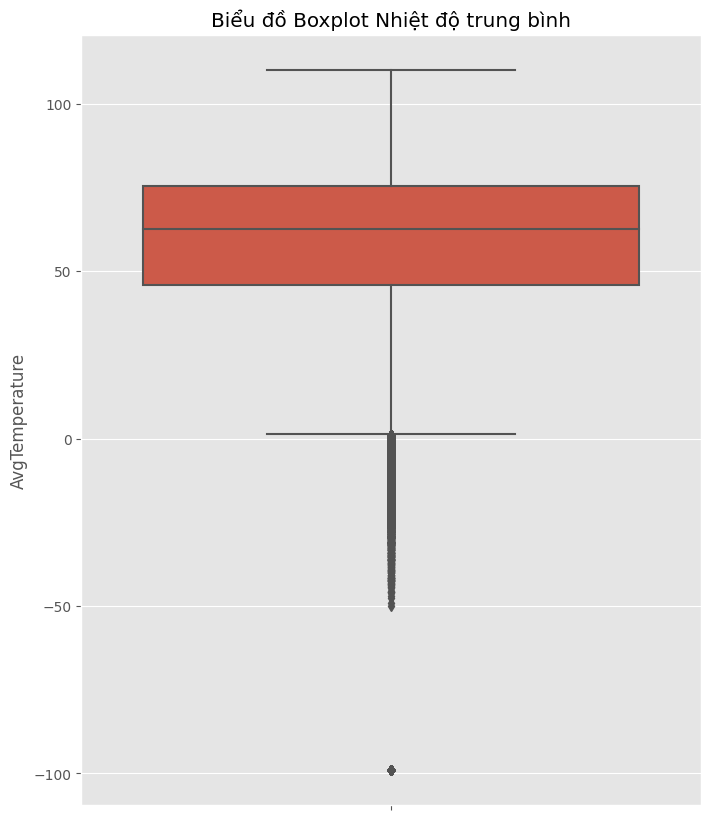

In [23]:
plt.figure(figsize = (8,10))
sns.boxplot(data = df,y = 'AvgTemperature')
_=plt.title("Biểu đồ Boxplot Nhiệt độ trung bình")

# **Bước 3: Trực quan hoá dữ liệu**



In [24]:
import plotly.express as px
data = df[['Country','Year','AvgTemperature']].groupby(['Country','Year']).mean().reset_index()
px.choropleth(data_frame=data,locations="Country",locationmode='country names',animation_frame="Year",color='AvgTemperature',color_continuous_scale = 'Turbo',title="Biểu đồ nhiệt độ trung bình theo quốc gia trong những năm 1995 đến 2019")

In [25]:
df.groupby('Region')['AvgTemperature'].agg(['mean', 'median', 'std'])

,mean,median,std
Region,,,
Africa,53.623665,75.0,56.982889
Asia,62.568652,74.7,35.655674
Australia/South Pacific,61.180869,62.0,16.540594
Europe,46.808889,51.9,31.175564
Middle East,68.384554,73.9,34.446461
North America,55.303906,58.3,22.401255
South/Central America & Carribean,62.190173,73.9,41.511919


Region
Africa                               53.623665
Asia                                 62.568652
Australia/South Pacific              61.180869
Europe                               46.808889
Middle East                          68.384554
North America                        55.303906
South/Central America & Carribean    62.190173
Name: AvgTemperature, dtype: float64


Text(0.5, 1.0, 'Nhiệt độ trung bình theo khu vực')

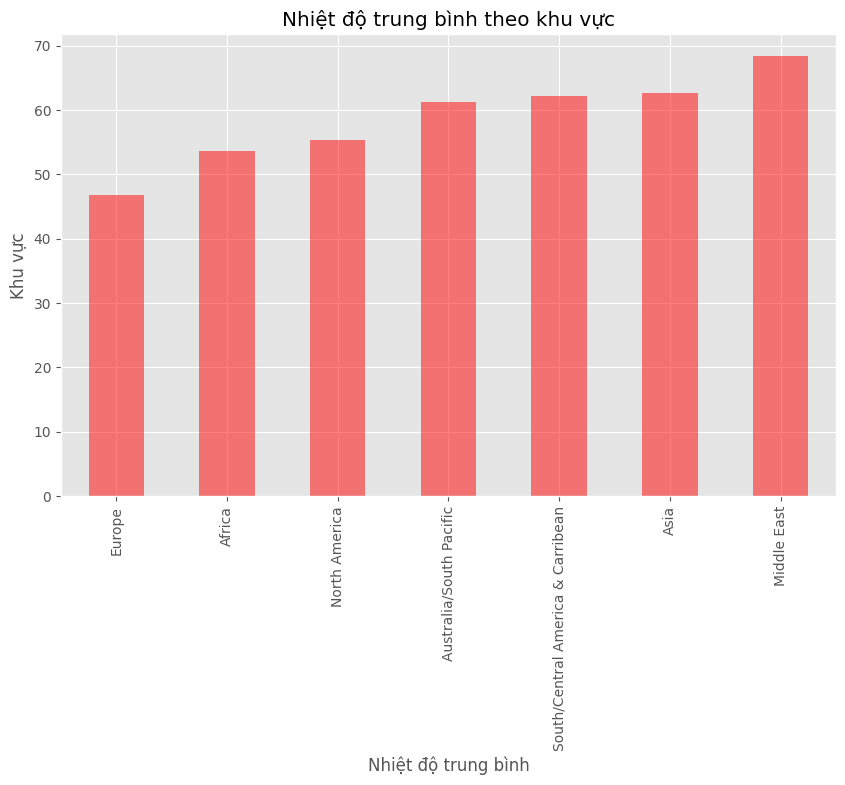

In [26]:
print(df.groupby(['Region'])['AvgTemperature'].mean())
avg_temp_world = pd.Series(round(df.groupby('Region')['AvgTemperature'].mean().sort_values(),2))
avg_temp_world.plot(kind='bar', figsize = (10,6), color='red', alpha=0.5)
plt.xlabel('Nhiệt độ trung bình')
plt.ylabel('Khu vực')
plt.title('Nhiệt độ trung bình theo khu vực')

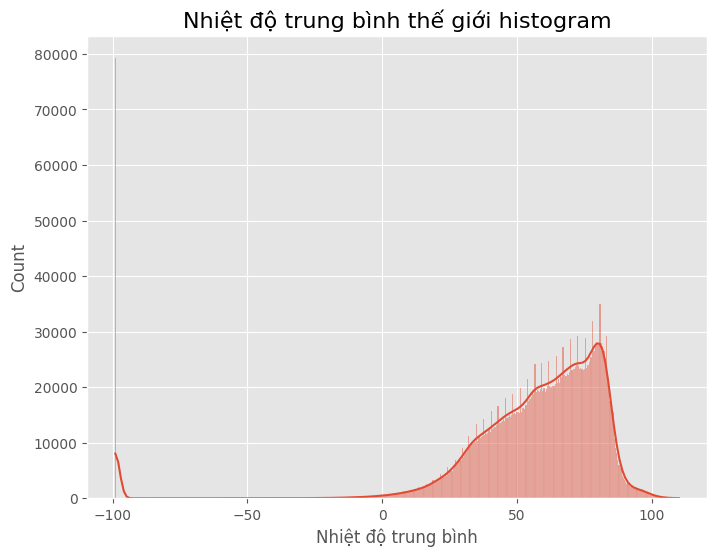

In [27]:
plt.figure(figsize= (8, 6))
ax = sns.histplot(data= df, x= 'AvgTemperature', kde= True)
ax.set_title('Nhiệt độ trung bình thế giới histogram', fontsize= 16)
ax.set_xlabel('Nhiệt độ trung bình')
plt.show()

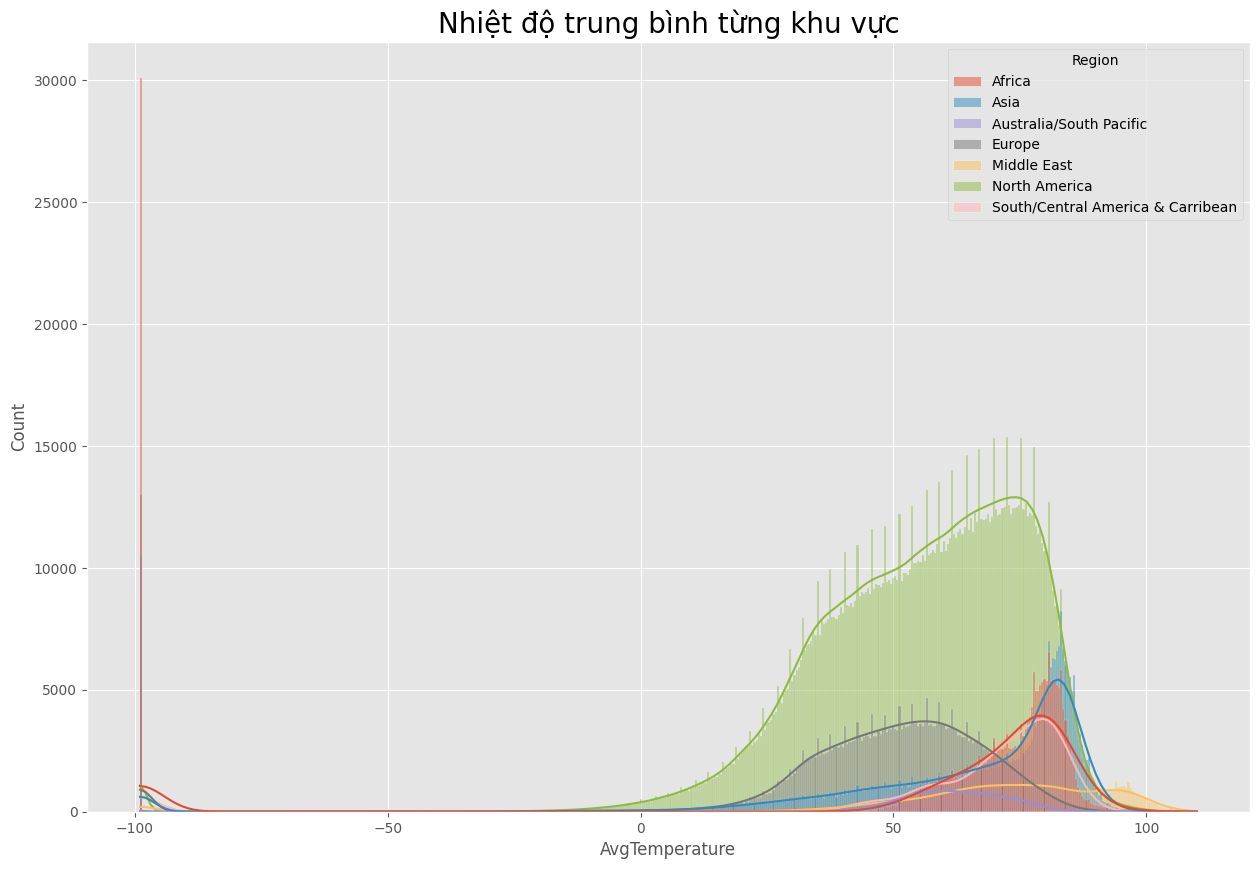

In [28]:
plt.figure(figsize= (15, 10))
ax = sns.histplot(data= df, x= 'AvgTemperature', hue= 'Region', kde= True)
ax.set_title('Nhiệt độ trung bình từng khu vực', fontsize= 20)
plt.show()

In [29]:
data = df[['Year','AvgTemperature']].groupby('Year').mean()
linfit = np.polyfit(data.index,data['AvgTemperature'],deg=1)
linfit = linfit[0]*data.index + linfit[1]
fig = px.line(data,title='Nhiệt độ trung bình thế giới từ năm 1995 đến năm 2020')
fig.add_trace(go.Scatter(x=data.index,y=linfit,name='Linear Fit'))

In [30]:
df.sort_values(by = ['AvgTemperature'], ascending  = False).head(5)

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
1034962,Middle East,Kuwait,Kuwait,8,1,2012,110.0,2012-08-01
1032390,Middle East,Kuwait,Kuwait,7,17,2005,109.9,2005-07-17
1036042,Middle East,Kuwait,Kuwait,7,17,2015,109.9,2015-07-17
1034963,Middle East,Kuwait,Kuwait,8,2,2012,109.9,2012-08-02
1036756,Middle East,Kuwait,Kuwait,6,29,2017,109.9,2017-06-29


In [31]:
df.sort_values(by = ['AvgTemperature'], ascending  = True).head(5)

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
90252,Africa,Guinea-Bissau,Bissau,4,8,2003,-99.0,2003-04-08
80077,Africa,Guinea,Conakry,10,11,2000,-99.0,2000-10-11
80076,Africa,Guinea,Conakry,10,10,2000,-99.0,2000-10-10
80075,Africa,Guinea,Conakry,10,9,2000,-99.0,2000-10-09
80074,Africa,Guinea,Conakry,10,8,2000,-99.0,2000-10-08


# **Bước 4:**

In [32]:
df = df[df['AvgTemperature']>-80]

In [33]:
data = df[df['Country'] == 'China']

In [34]:
bj = data[data['City'] == 'Beijing']

In [35]:
bj

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
256928,Asia,China,Beijing,1,1,1995,28.0,1995-01-01
256929,Asia,China,Beijing,1,2,1995,29.0,1995-01-02
256930,Asia,China,Beijing,1,3,1995,29.9,1995-01-03
256931,Asia,China,Beijing,1,4,1995,34.5,1995-01-04
256932,Asia,China,Beijing,1,5,1995,36.6,1995-01-05
...,...,...,...,...,...,...,...,...
266189,Asia,China,Beijing,5,9,2020,60.6,2020-05-09
266190,Asia,China,Beijing,5,10,2020,69.4,2020-05-10
266191,Asia,China,Beijing,5,11,2020,73.0,2020-05-11
266192,Asia,China,Beijing,5,12,2020,66.5,2020-05-12


In [36]:
preprocessed_df=bj
preprocessed_df

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
256928,Asia,China,Beijing,1,1,1995,28.0,1995-01-01
256929,Asia,China,Beijing,1,2,1995,29.0,1995-01-02
256930,Asia,China,Beijing,1,3,1995,29.9,1995-01-03
256931,Asia,China,Beijing,1,4,1995,34.5,1995-01-04
256932,Asia,China,Beijing,1,5,1995,36.6,1995-01-05
...,...,...,...,...,...,...,...,...
266189,Asia,China,Beijing,5,9,2020,60.6,2020-05-09
266190,Asia,China,Beijing,5,10,2020,69.4,2020-05-10
266191,Asia,China,Beijing,5,11,2020,73.0,2020-05-11
266192,Asia,China,Beijing,5,12,2020,66.5,2020-05-12


In [37]:
bj = data.loc[data['City'] == 'Beijing',['Month','Day','Year','AvgTemperature']].reset_index(drop=True)
bj.head(3)

,Month,Day,Year,AvgTemperature
0,1,1,1995,28.0
1,1,2,1995,29.0
2,1,3,1995,29.9


In [38]:
size = bj.groupby(['Year','Month']).size().reset_index()
size_max = size[0].max()
size_min = size[0].min()
n = size_max - size_min +1
cmap = sns.color_palette("deep",n)
size = size.pivot(index='Year',columns='Month',values=0)
size.head(3)

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
1995,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
1996,31.0,29.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0
1997,31.0,28.0,31.0,30.0,31.0,30.0,31.0,31.0,30.0,31.0,30.0,31.0


In [39]:
bj['Date'] = bj[['Year','Month','Day']].apply(lambda row:'-'.join([str(row['Year']),str(row['Month']),str(row['Day'])]),axis=1)
bj['Date'] = pd.to_datetime(bj['Date'])
bj = bj.drop(columns=['Month','Day','Year']).set_index('Date')
bj.head(3)

,AvgTemperature
Date,
1995-01-01,28.0
1995-01-02,29.0
1995-01-03,29.9


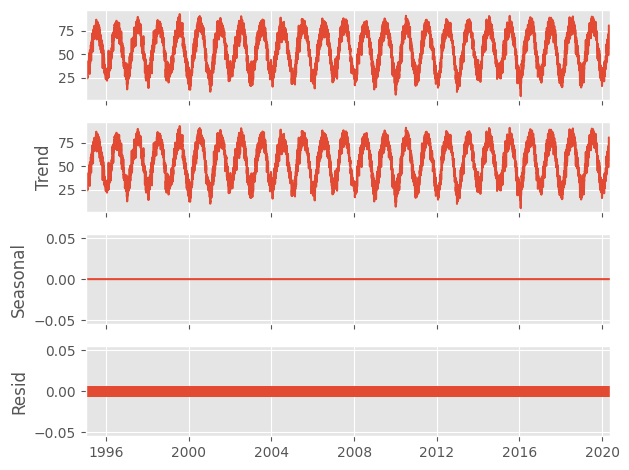

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(bj,period=1)
decompose.plot();

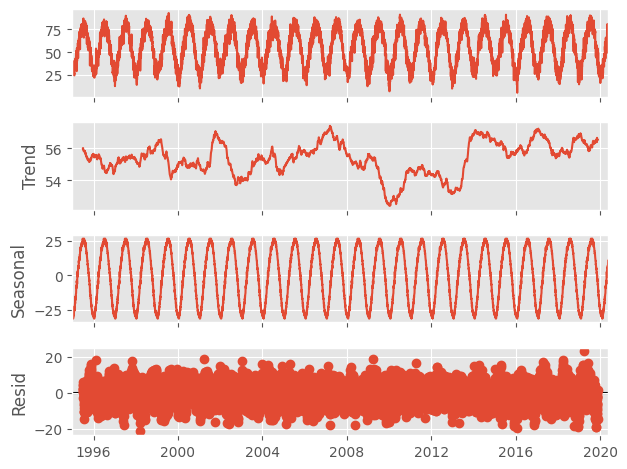

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(bj,period=365)
decompose.plot();

In [42]:
px.line(data_frame=bj,color_discrete_sequence=['grey'],title="Nhiệt độ trung bình - Bejing (1995-2019)")

In [43]:
roll_mean = bj.rolling(window=31).mean()
roll_mean2 = bj.rolling(window=365).mean()
fig = go.Figure()
fig.add_trace(go.Scatter(x=bj.index,y=bj['AvgTemperature'],marker=dict(color='grey'),name='Daily'))
fig.add_trace(go.Scatter(x=roll_mean.index,y=roll_mean['AvgTemperature'],marker=dict(color='red'),name='31DaysRolling'))
fig.add_trace(go.Scatter(x=roll_mean2.index,y=roll_mean2['AvgTemperature'],marker=dict(color='green'),name='365DaysRolling'))
fig.update_layout(dict(title='Rolling Mean'))

In [44]:
roll_mean = bj.rolling(window=31).std()
roll_mean2 = bj.rolling(window=365).std()
fig = go.Figure()
fig.add_trace(go.Scatter(x=roll_mean.index,y=roll_mean['AvgTemperature'],marker=dict(color='red'),name='31DaysRolling'))
fig.add_trace(go.Scatter(x=roll_mean2.index,y=roll_mean2['AvgTemperature'],marker=dict(color='green'),name='365DaysRolling'))
fig.update_layout(dict(title='Rolling Std'))

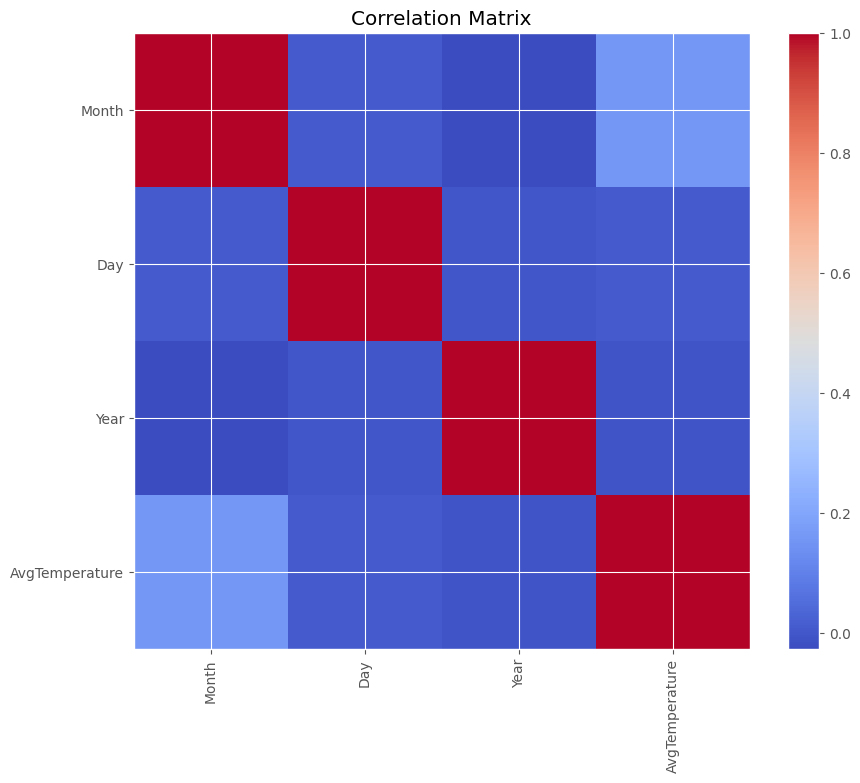

In [45]:
correlation_matrix = preprocessed_df.corr()
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Matrix')
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.show()

In [46]:
# Daily Consumption
ma = bj.resample('D').mean()
# 3 Day Example
ma['Moving Average'] = ma['AvgTemperature'].rolling(3).mean()
ma.head()

,AvgTemperature,Moving Average
Date,,
1995-01-01,28.0,NaN
1995-01-02,29.0,NaN
1995-01-03,29.9,28.966667
1995-01-04,34.5,31.133333
1995-01-05,36.6,33.666667


In [47]:
def moving_average(data, window):
    data['Moving Average'] = data['AvgTemperature'].rolling(window).mean()
    actual = data['AvgTemperature'][-(window+30):]
    ma = data['Moving Average'][-(window+30):]

    plt.figure(figsize=(20,8))
    actual.plot(label='Actual', lw=4)
    ma.plot(label='MA-{}'.format(str(window)), ls='--', lw=2)
    plt.title('{}-Ngày Moving Average'.format(str(window)), weight='bold', fontsize=25)
    plt.legend()

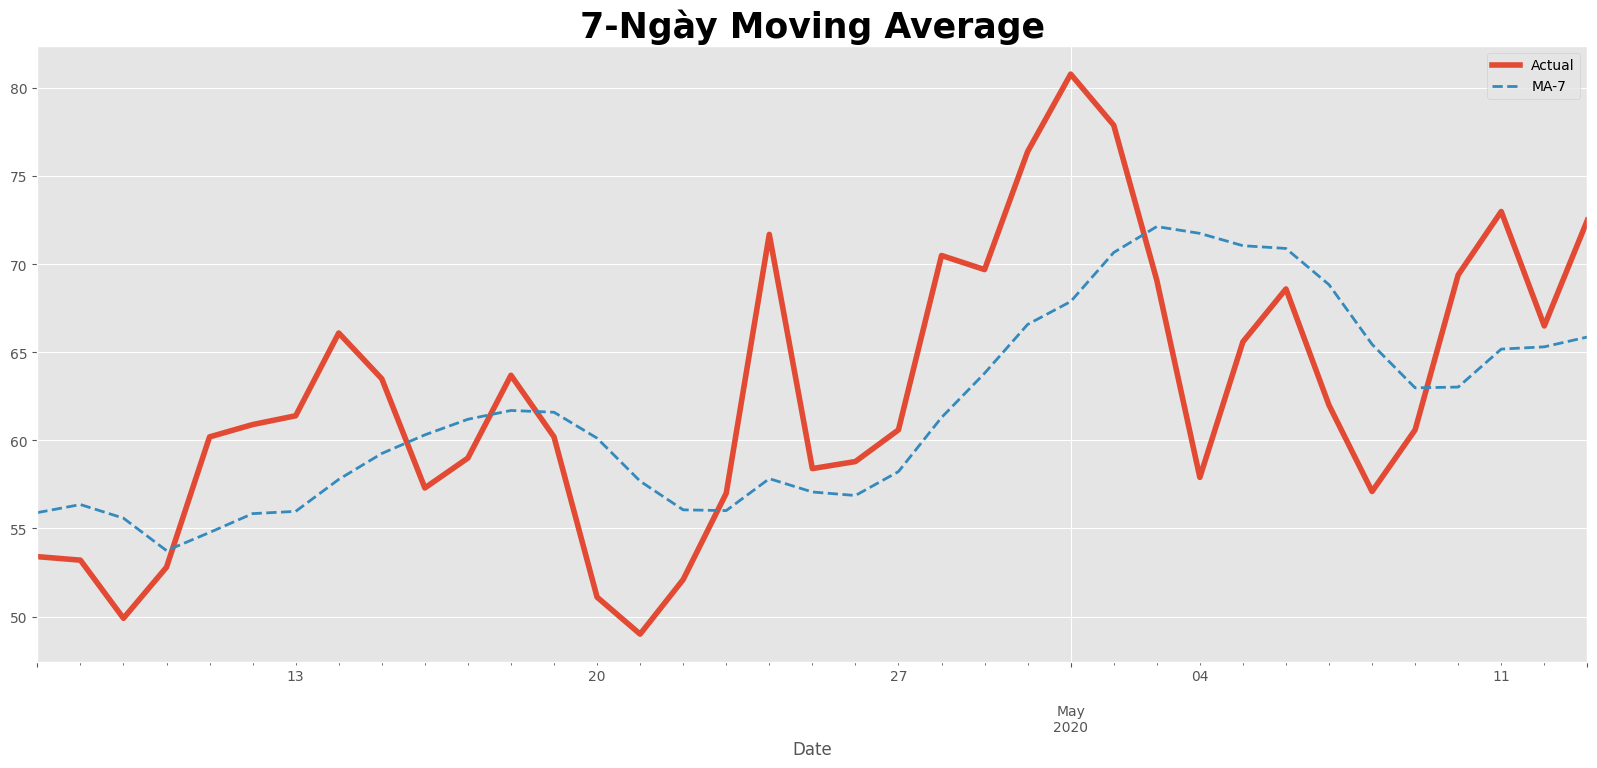

In [48]:
moving_average(ma, 7)

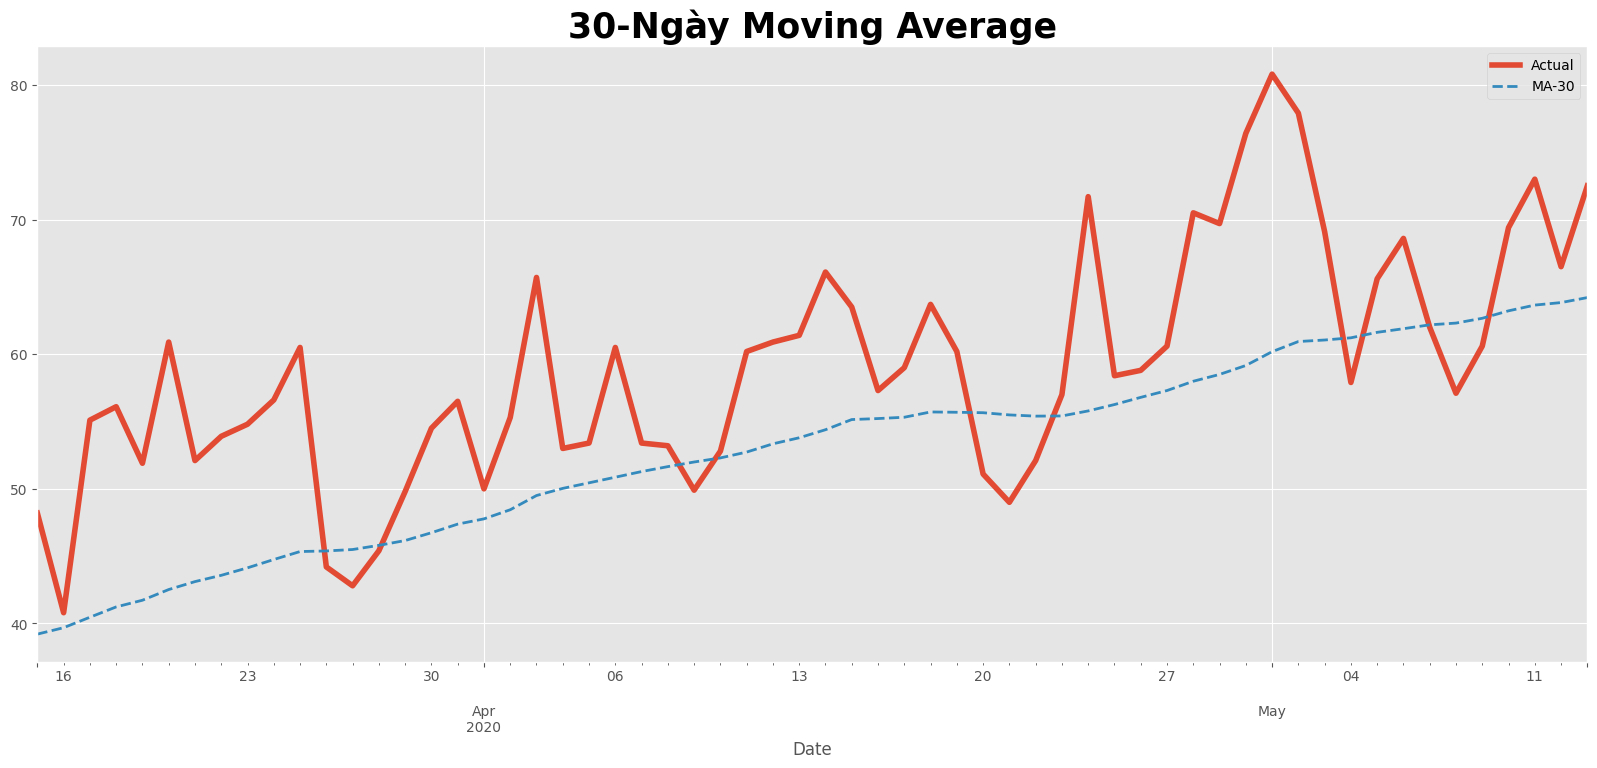

In [49]:
moving_average(ma, 30)

In [50]:
# Xác định đặc trưng và biến phụ thuộc
features = ['Month', 'Day', 'Year']
target = 'AvgTemperature'

# Tạo DataFrame mới với các cột được chọn
selected_data = preprocessed_df[features + [target]]

In [51]:
selected_data.head()

,Month,Day,Year,AvgTemperature
256928,1,1,1995,28.0
256929,1,2,1995,29.0
256930,1,3,1995,29.9
256931,1,4,1995,34.5
256932,1,5,1995,36.6


In [52]:
X = selected_data[features]
y = selected_data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
print("Kích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape)

Kích thước tập huấn luyện: (7389, 3)
Kích thước tập kiểm tra: (1848, 3)


In [54]:
linear_model = LinearRegression()

In [55]:
linear_model.fit(X_train, y_train)

LinearRegression()

In [56]:
y_pred_linear = linear_model.predict(X_test)

In [57]:
# Đánh giá mô hình
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f"RMSE for Linear Regression: {rmse_linear}")

RMSE for Linear Regression: 19.863678696214098


In [58]:
# Khởi tạo mô hình
tree_model = DecisionTreeRegressor(random_state=42)

In [59]:
# Huấn luyện mô hình
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [60]:
# Dự đoán trên tập kiểm tra
y_pred_tree = tree_model.predict(X_test)

In [61]:
print("Giá trị dự đoán trên tập kiểm tra (Decision Tree):", y_pred_tree)

Giá trị dự đoán trên tập kiểm tra (Decision Tree): [34.1 49.1 29.  ... 61.9 68.9 20.9]


In [62]:
# Đánh giá mô hình
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print(f"RMSE for Decision Tree: {rmse_tree}")

RMSE for Decision Tree: 5.2894063243495735


In [63]:
# Khởi tạo mô hình
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [64]:
# Huấn luyện mô hình
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [65]:
# Dự đoán trên tập kiểm tra
y_pred_rf = rf_model.predict(X_test)

In [66]:
print("Giá trị dự đoán trên tập kiểm tra (Random Forest):", y_pred_rf)

Giá trị dự đoán trên tập kiểm tra (Random Forest): [33.445 59.653 31.463 ... 60.585 67.142 22.019]


In [67]:
# Đánh giá mô hình
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE for Random Forest: {rmse_rf}")

RMSE for Random Forest: 4.242383145247758


In [68]:
# Khởi tạo mô hình
xgb_model = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)

In [69]:
# Huấn luyện mô hình
xgb_model.fit(X_train, y_train)


XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

In [70]:
# Dự đoán trên tập kiểm tra
y_pred_xgb = xgb_model.predict(X_test)

In [71]:
print("Giá trị dự đoán trên tập kiểm tra (XGBoot):", y_pred_xgb)

Giá trị dự đoán trên tập kiểm tra (XGBoot): [30.002424 69.631584 45.77297  ... 57.88432  69.514435 27.515879]


In [72]:
# Đánh giá mô hình
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE for XGBoost: {rmse_xgb}")

RMSE for XGBoost: 6.194782905514192


In [73]:
# Lọc ra các cột dạng số
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns

Index(['Month', 'Day', 'Year', 'AvgTemperature'], dtype='object')

In [74]:
# Chuẩn hóa dữ liệu
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_data_lstm = scaler_lstm.fit_transform(preprocessed_df[numeric_columns])

In [75]:
# Hàm tạo dãy thời gian dạng chuỗi
def create_sequences(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        end_ix = i + time_steps
        seq_x, seq_y = data[i:end_ix, :-1], data[end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [76]:
# Xây dựng dãy thời gian dạng chuỗi
X, y = create_sequences(scaled_data_lstm, time_steps=10)

In [77]:
# Chia tập dữ liệu
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
# Xây dựng mô hình LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(LSTM(units=50, return_sequences=True))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(units=X_train_lstm.shape[2]))
model_lstm.add(Dense(units=1))

In [79]:
# Biên soạn và huấn luyện mô hình
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test_lstm))

Epoch 1/50
231/231 [==============================] - 13s 26ms/step - loss: 0.0408 - val_loss: 0.0064
Epoch 2/50
231/231 [==============================] - 7s 29ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 3/50
231/231 [==============================] - 5s 24ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 4/50
231/231 [==============================] - 5s 21ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 5/50
231/231 [==============================] - 7s 32ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 6/50
231/231 [==============================] - 4s 19ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 7/50
231/231 [==============================] - 5s 23ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 8/50
231/231 [==============================] - 6s 26ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 9/50
231/231 [==============================] - 5s 19ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 10/50
231/231 [==============================] - 5s 22ms/step - loss: 0.0044 - val_l

In [80]:
# Dự đoán trên tập kiểm tra
y_pred_lstm = model_lstm.predict(X_test_lstm)[:, -1]

58/58 [==============================] - 2s 9ms/step


In [81]:
print("Giá trị dự đoán trên tập kiểm tra (LSTM):", y_pred_lstm)

Giá trị dự đoán trên tập kiểm tra (LSTM): [0.56960446 0.44399768 0.71449983 ... 0.19994627 0.4937039  0.22210196]


In [82]:
# Kiểm tra kích thước của y_true và y_pred
print("Shape of y_true:", y_test_lstm.shape)
print("Shape of y_pred:", y_pred_lstm.shape)

Shape of y_true: (1846,)
Shape of y_pred: (1846,)


In [83]:
# Đánh giá mô hình
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
print(f"RMSE for LSTM: {rmse_lstm}")

RMSE for LSTM: 0.060680988996731244


In [84]:
from statsmodels.tsa.stattools import adfuller

# Thực hiện Augmented Dickey-Fuller Test
result = adfuller(preprocessed_df['AvgTemperature'],regression='c',maxlag=12)

# In kết quả
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -4.4695701217579735
p-value: 0.00022309260745725167
Critical Values: {'1%': -3.4310589876822637, '5%': -2.8618533274865428, '10%': -2.5669367791530067}


In [85]:
result1 = adfuller(np.diff(preprocessed_df['AvgTemperature']),regression='n',maxlag=12)
print('ADF Statistic:', result1[0])
print('p-value:', result1[1])
print('Critical Values:', result1[4])

ADF Statistic: -37.450228650761
p-value: 0.0
Critical Values: {'1%': -2.565982405763765, '5%': -1.9410291560328188, '10%': -1.6167912405314357}


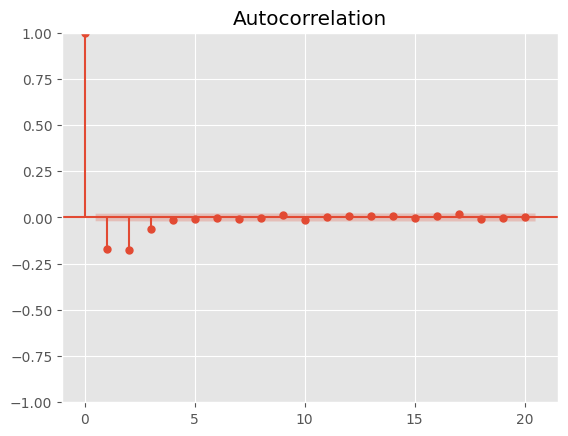

In [86]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

plot_acf(np.diff(preprocessed_df['AvgTemperature']),lags=20)
plt.show()


Lag 	 ACF
0 	 1.0
1 	 -0.17010495264344783
2 	 -0.17343445451279885
3 	 -0.059901178296847386
4 	 -0.014014497819388893
5 	 -0.010019020218675194
6 	 -0.0009361977308097971
7 	 -0.009386400283121595
8 	 -0.00027604361618545277
9 	 0.015413318493187386
10 	 -0.015236528456447122
11 	 0.0032448487454374403
12 	 0.005602515464263218
13 	 0.00923650038960163
14 	 0.00831270706666522
15 	 -0.0007964846147837405
16 	 0.009138918318278849
17 	 0.019295640485864834
18 	 -0.007698437724398802
19 	 -0.0025055218547405827
20 	 0.004074590012127849


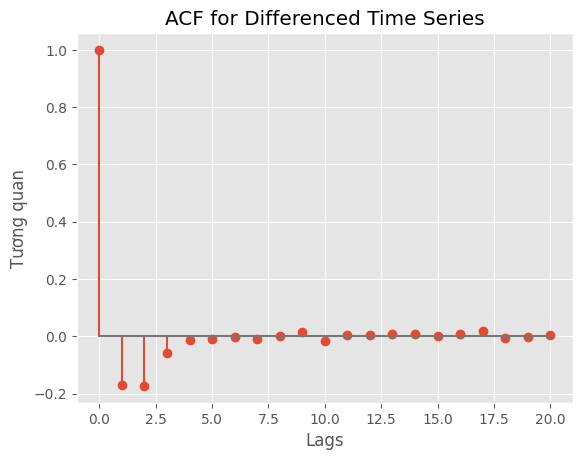

In [104]:
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt
import numpy as np

# Tính toán giá trị ACF cho chuỗi thời gian chênh lệch
lags = 20
acf_values, confint = acf(np.diff(preprocessed_df['AvgTemperature']), nlags=lags, alpha=0.5)

# In giá trị lag và tương ứng giá trị ACF
print("Lag \t ACF")
for lag in range(lags + 1):
    print(f"{lag} \t {acf_values[lag]}")

# Hiển thị đồ thị ACF
plt.stem(range(lags + 1), acf_values, use_line_collection=True)
plt.title('ACF for Differenced Time Series')
plt.xlabel('Lags')
plt.ylabel('Tương quan')
plt.show()


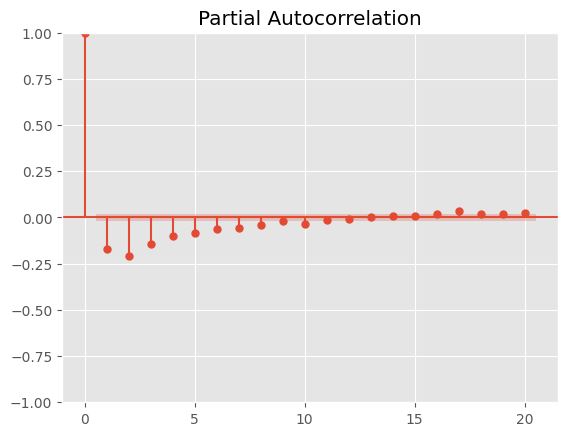

In [92]:
plot_pacf(np.diff(preprocessed_df['AvgTemperature']),lags=20)
plt.show()

Lag 	 PACF
0 	 1.0
1 	 0.9745169330912794
2 	 0.1597920196668953
3 	 0.20053439817038618
4 	 0.13665273812689038
5 	 0.09972428629570976
6 	 0.08190556375845354
7 	 0.05804372311041415
8 	 0.05496666005967931
9 	 0.038855737709657064
10 	 0.015174241773976044
11 	 0.03175815947324232
12 	 0.012517889571841578
13 	 0.006511222189161794
14 	 -0.0046684604655583585
15 	 -0.012057400457206047
16 	 -0.009332425000980124
17 	 -0.021207395455234243
18 	 -0.03845346290905297
19 	 -0.020596793939759068
20 	 -0.02485626723478873


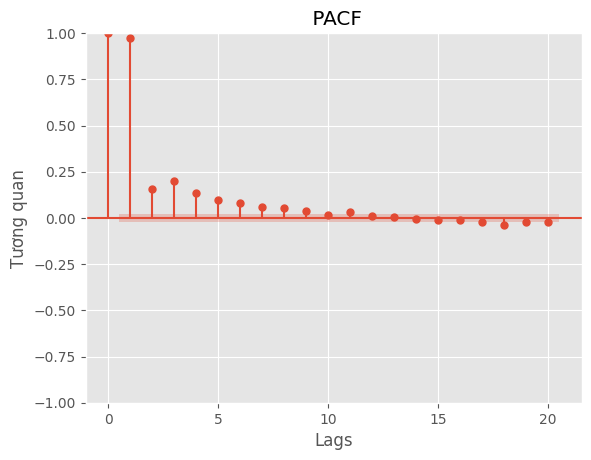

In [87]:

time_series_data=preprocessed_df['AvgTemperature']
lags = 20
pacf_values, confint = pacf(time_series_data, nlags=lags, alpha=0.05)

# In giá trị lag và tương ứng giá trị PACF
print("Lag \t PACF")
for lag, pacf_val in enumerate(pacf_values):
    print(f"{lag} \t {pacf_val}")

# Vẽ biểu đồ PACF
plot_pacf(time_series_data, lags=lags)
plt.title(' PACF')
plt.xlabel('Lags')
plt.ylabel('Tương quan')
plt.show()

In [88]:
preprocessed_df

,Region,Country,City,Month,Day,Year,AvgTemperature,Date
256928,Asia,China,Beijing,1,1,1995,28.0,1995-01-01
256929,Asia,China,Beijing,1,2,1995,29.0,1995-01-02
256930,Asia,China,Beijing,1,3,1995,29.9,1995-01-03
256931,Asia,China,Beijing,1,4,1995,34.5,1995-01-04
256932,Asia,China,Beijing,1,5,1995,36.6,1995-01-05
...,...,...,...,...,...,...,...,...
266189,Asia,China,Beijing,5,9,2020,60.6,2020-05-09
266190,Asia,China,Beijing,5,10,2020,69.4,2020-05-10
266191,Asia,China,Beijing,5,11,2020,73.0,2020-05-11
266192,Asia,China,Beijing,5,12,2020,66.5,2020-05-12


In [89]:
import math
X =preprocessed_df[features + [target]].copy()
y = preprocessed_df['AvgTemperature'].copy()

train_size = int(0.80 * len(preprocessed_df))
test_size = len(preprocessed_df) - train_size

X_train, y_train = pd.DataFrame(X.iloc[:train_size]), pd.DataFrame(y.iloc[:train_size])
X_test, y_test = pd.DataFrame(X.iloc[train_size:]), pd.DataFrame(y.iloc[train_size:])

print(len(X_train), len(X_test))

model = ARIMA(y_train, order=(13,0,13))
model_fit = model.fit()

y_pred = model_fit.forecast(len(X_test))

score_mae = mean_absolute_error(y_test, y_pred)
score_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: {}'.format(score_rmse))



7389 1848
RMSE: 20.70978613919111


In [90]:
# In kết quả RMSE
print(f"RMSE Linear Regression: {rmse_linear}")
print(f"RMSE Decision Tree: {rmse_tree}")
print(f"RMSE Random Forest: {rmse_rf}")
print(f"RMSE XGBoost: {rmse_xgb}")
print(f"RMSE LSTM: {rmse_lstm}")
print(f"RMSE Arima: {score_rmse}")

RMSE Linear Regression: 19.863678696214098
RMSE Decision Tree: 5.2894063243495735
RMSE Random Forest: 4.242383145247758
RMSE XGBoost: 6.194782905514192
RMSE LSTM: 0.060680988996731244
RMSE Arima: 20.70978613919111


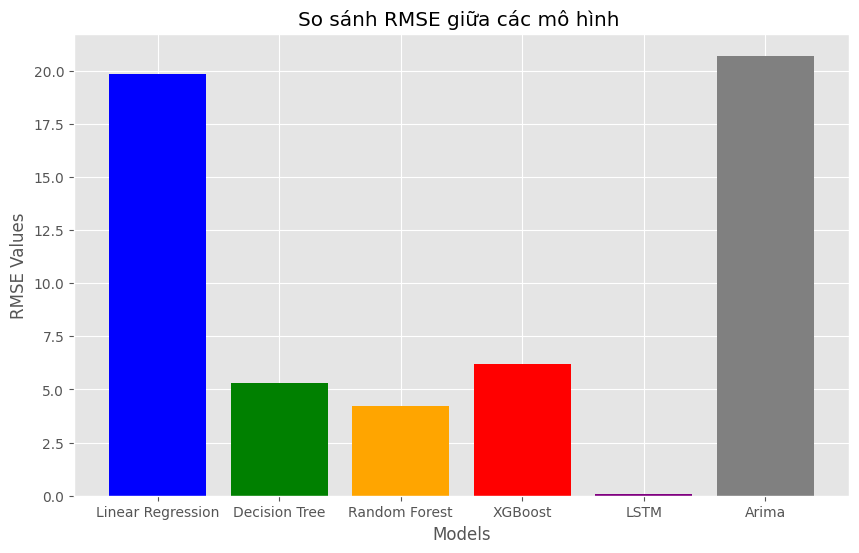

In [91]:
import matplotlib.pyplot as plt

models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LSTM','Arima']

rmse_values = [rmse_linear, rmse_tree, rmse_rf, rmse_xgb, rmse_lstm,score_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange', 'red', 'purple','gray'])
plt.title('So sánh RMSE giữa các mô hình ')
plt.xlabel('Models')
plt.ylabel('RMSE Values')

plt.show()
